# Question
The following figures show the Di Wang Tower in Shenzhen. The structure of Di Wang Tower is made up of steel and reinforced concrete (calculated as reinforced concrete), C terrain type, the design wind pressure $w_0 = 0.75 \text{ kN/m}^2$, period $T_1=6.38\text{ s}$, The first mode shape is listed in following table. To determine shape factor, the cross section could be considered as rectangle.

<center>
    <img src="./images/Diwang01.png" alt="The Elvation of the DiWang Tower" width="400"/>
    <img src="./images/Diwang02.png" alt="The Plan View of the DiWang Tower" width="400"/>
</center>

<br>

| $\dfrac{h}{H}$ | 0     | 0.1   | 0.2   | 0.3   | 0.4    | 0.5   | 0.6   | 0.7    | 0.8   | 0.9   | 1.0   |
| -------------- | ----- | ----- | ----- | ----- | ------ | ----- | ----- | ------ | ----- | ----- | ----- |
| Mode shape     | 0.0000| 0.0137| 0.0558| 0.1277| 0.2424| 0.3503| 0.4629| 0.5903| 0.7309| 0.8700| 1.0000| 
| Mass / ton     | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 2500  | 1500  | 

Only consider the first mode, calculate **the extreme of top displacements** induced by the along-wind static and dynamic wind load in the given wind direction using the following methods:
1. Method recommended by the Chinese code for wind-resistant design of buildings (GB 50009-2012).
2. According to the quasi-steady assumption, convert the fluctuating wind velocity time histories in `windData` (**with a duration of 10 minutes and a sampling frequency of 10 Hz**) to wind load time histories $F_i(t)=[1/2\rho \bar{u_i}^2+\rho \bar{u_i} u'_i(t)] \cdot \mu_{s,i} \cdot A_i$, and then using stocastic vibration methods in time domain (such as the newmark-beta algorithm) and in frequency domain (such as the response spectrum analysis). Peak factor $g = 2.5$ should be used for the extreme value calculation, and the programming using frequency domain method is optional.

# Answer


In [3]:
import scipy.io as sio

# load data
simDataPath = './windData/windData.mat'
simData = sio.loadmat(simDataPath, squeeze_me=True, struct_as_record=False)
U = simData['U']
Z = simData['Z']
dt = simData['dt']
t = simData['t']
del simData
print("\nThe dimension of U is:", U.shape)


The dimension of U is: (11, 6000)



风速数据维度: (11, 6000)

=== 使用时域和频域方法计算 ===


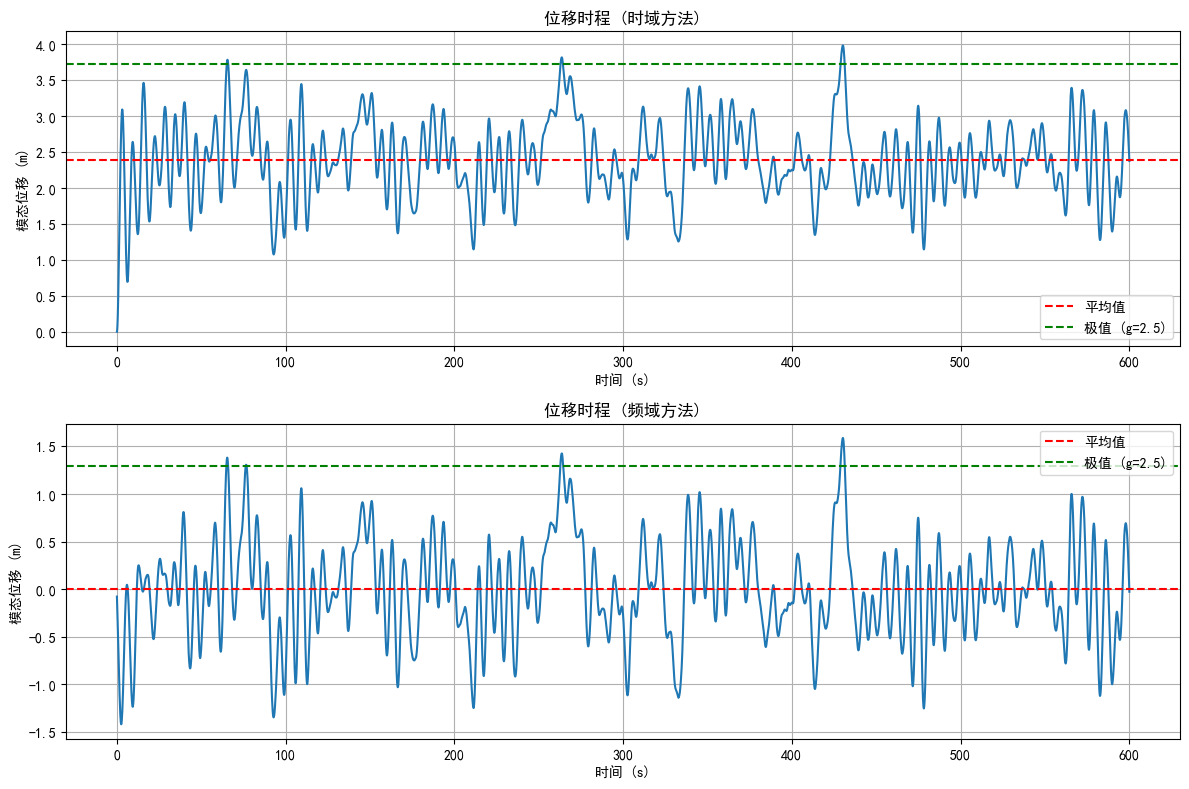

Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], substituting with a dummy symbol.
Font 'default' does not have a glyph for '\u2212' [U+2212], 

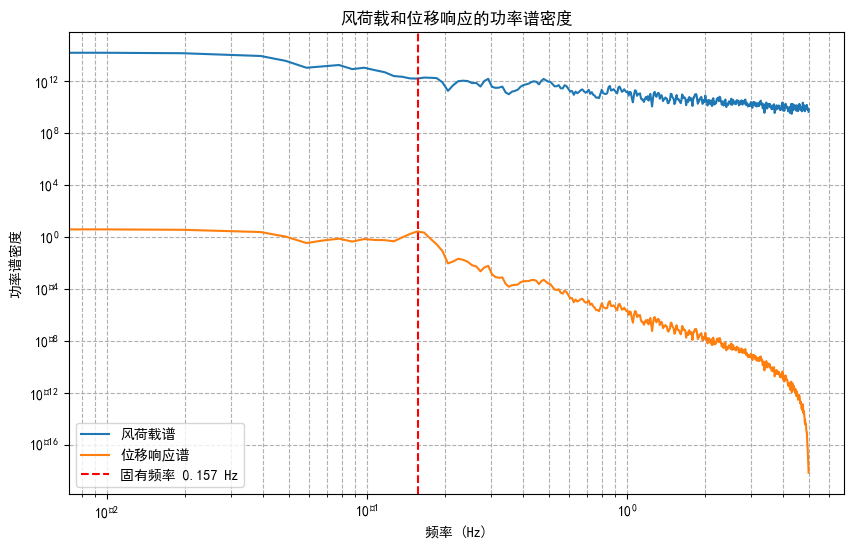

静力位移: 2.395196 m
动力位移 (时域): 1.329543 m
总位移极值 (时域): 3.724740 m
动力位移 (频域): 1.290470 m
总位移极值 (频域): 3.685666 m


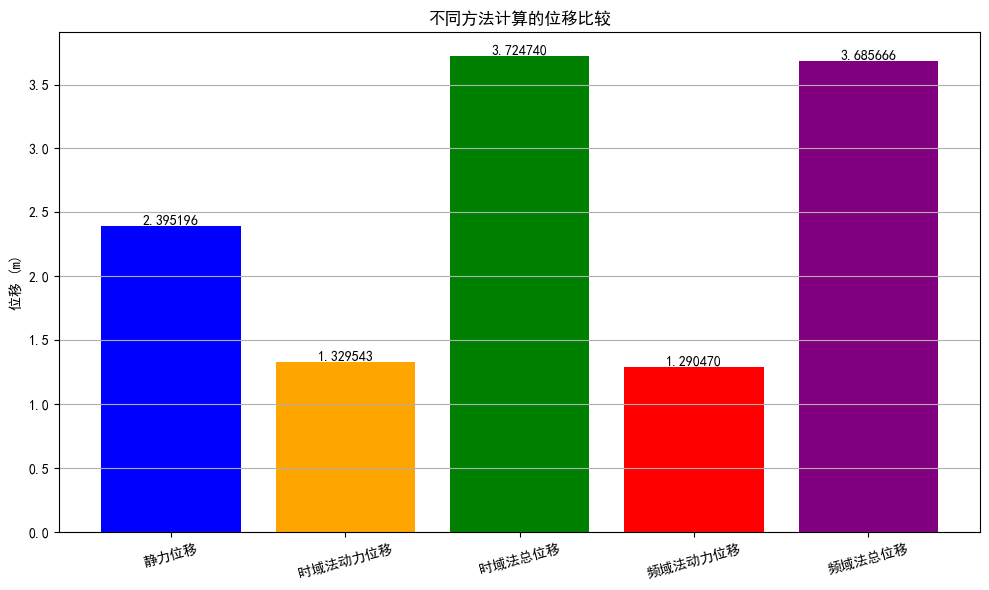

In [15]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, integrate
from scipy.fft import fft, ifft, fftfreq

# 设置中文字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False    # 用来正常显示负号

# load data
simDataPath = './windData/windData.mat'
simData = sio.loadmat(simDataPath, squeeze_me=True, struct_as_record=False)
U = simData['U']
Z = simData['Z']
dt = simData['dt']
t = simData['t']
del simData
print("\n风速数据维度:", U.shape)

# ---------- 结构与风场基本参数 ----------
# 结构参数
building_height = 303.46  # 建筑总高 (m)
building_width = 65.88    # 迎风面宽度 (m)
building_depth = 35.50    # 建筑宽度 (m)
period_1 = 6.38           # 第一阶自振周期 (s)
damping_ratio = 0.05      # 阻尼比

# 顶部圆柱参数
d_lower = 23.5  # 下部圆柱直径 (m)
h_lower = 6.49  # 下部圆柱高度 (m)
d_upper = 12.0  # 上部圆柱直径 (m)
h_upper = 15.0  # 上部圆柱高度 (m)

# 风场参数 (C类地形)
basic_wind_pressure = 0.75  # 基本风压 (kN/m²)
shape_coef = 1.4            # 体型系数（矩形截面）
peak_factor = 2.5           # 峰值因子
turbulence_intensity = 0.23 # C类地形10m高度湍流强度
terrain_factor_k = 0.295    # C类地形参数k
terrain_exponent = 0.261    # C类地形指数α1
fluctuating_wind_coef = 0.54 # C类地形脉动风参数kw

# 模态和质量分布
h_ratio = np.array([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
mode_shape = np.array([0.0000, 0.0137, 0.0558, 0.1277, 0.2424, 0.3503, 0.4629, 0.5903, 0.7309, 0.8700, 1.0000])
mass = np.array([2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 2500, 1500]) * 1000  # 转换为kg

# 计算各高度
heights = h_ratio * building_height

# 使用时域和频域方法计算风荷载下的顶部位移极值
def calculate_displacement_by_simulation():
    rho = 1.25  # 空气密度 (kg/m³)
    
    # 计算各高度处的平均风速和脉动风速
    mean_wind = np.mean(U, axis=1)
    fluct_wind = U - mean_wind[:, np.newaxis]
    
    # 插值得到模态形状和质量在测点高度上的值
    mode_shape_interp = np.interp(Z, heights, mode_shape)
    
    # 计算各高度处的面积
    areas = np.zeros_like(Z)
    for i in range(len(Z)):
        height_level = Z[i] / building_height
        
        if height_level < 0.93:  # 主体部分
            if i == 0:
                areas[i] = Z[i] * building_width
            else:
                areas[i] = (Z[i] - Z[i-1]) * building_width
        else:
            # 顶部圆柱体部分
            if height_level < 0.95:  # 下部圆柱
                if i == 0:
                    areas[i] = Z[i] * d_lower
                else:
                    areas[i] = (Z[i] - Z[i-1]) * d_lower
            else:  # 上部圆柱
                if i == 0:
                    areas[i] = Z[i] * d_upper
                else:
                    areas[i] = (Z[i] - Z[i-1]) * d_upper
    
    # 计算风荷载时程
    # F_i(t) = [1/2*rho*u_i^2 + rho*u_i*u'_i(t)] * mu_s * A_i
    # 修复：确保 F_static 的形状与 F_dynamic 兼容
    mean_wind_2d = mean_wind[:, np.newaxis]  # 形状变为 (11,1)
    F_static = 0.5 * rho * mean_wind_2d**2 * shape_coef * areas[:, np.newaxis]  # 形状为 (11,1)
    F_dynamic = rho * mean_wind_2d * fluct_wind * shape_coef * areas[:, np.newaxis]  # 形状为 (11,6000)
    F_total = F_static + F_dynamic  # 广播后形状为 (11,6000)
    
    # 计算广义风荷载时程
    F_gen = np.zeros(len(t))
    for i in range(len(Z)):
        F_gen += F_total[i, :] * mode_shape_interp[i]
    
    # 计算固有频率和振动特性
    natural_freq = 1 / period_1  # Hz
    circular_freq = 2 * np.pi * natural_freq  # rad/s
    
    # 计算模态质量和刚度
    modal_mass = np.sum(mass[1:] * mode_shape[1:]**2)  # 不包括地面点
    modal_stiffness = modal_mass * circular_freq**2  # N/m
    
    # 计算阻尼系数
    modal_damping = 2 * damping_ratio * np.sqrt(modal_mass * modal_stiffness)  # N·s/m
    
    # 时域方法 - Newmark-β算法
    def newmark_beta(F, dt, m, c, k, beta=0.25, gamma=0.5):
        n = len(F)
        x = np.zeros(n)
        v = np.zeros(n)
        a = np.zeros(n)
        
        # 初始条件
        x[0] = 0
        v[0] = 0
        a[0] = (F[0] - c * v[0] - k * x[0]) / m
        
        # Newmark-β迭代
        for i in range(1, n):
            # 预测步
            x_pred = x[i-1] + dt*v[i-1] + 0.5*dt**2*a[i-1]
            v_pred = v[i-1] + dt*a[i-1]
            
            # 修正步
            a[i] = (F[i] - c*v_pred - k*x_pred) / m
            x[i] = x_pred + beta*dt**2*(a[i] - a[i-1])
            v[i] = v_pred + gamma*dt*(a[i] - a[i-1])
        
        return x, v, a
    
    # 使用Newmark-β算法计算位移时程
    x_time, v_time, a_time = newmark_beta(F_gen, dt, modal_mass, modal_damping, modal_stiffness)
    
    # 频域方法 - 响应谱分析
    def frequency_domain_analysis(F, dt, m, c, k):
        n = len(F)
        
        # 计算FFT
        F_fft = fft(F)
        freq = fftfreq(n, dt)
        
        # 计算频率响应函数 (仅计算正频率部分)
        pos_freq_idx = np.where(freq > 0)
        omega = 2 * np.pi * freq
        
        # 初始化频率响应函数
        H = np.zeros(len(freq), dtype=complex)
        
        # 计算频响函数 H(ω) = 1/[k - mω² + jcω]
        for idx in pos_freq_idx[0]:
            H[idx] = 1.0 / complex(k - m * omega[idx]**2, c * omega[idx])
        
        # 负频率部分取共轭
        for i in range(1, n//2):
            H[n-i] = np.conj(H[i])
        
        # 计算位移的FFT
        X_fft = F_fft * H
        
        # 计算位移时程
        x = np.real(ifft(X_fft))
        
        # 返回位移和频率
        return x, freq
    
    # 使用频域方法计算位移时程
    x_freq, freq = frequency_domain_analysis(F_gen, dt, modal_mass, modal_damping, modal_stiffness)
    
    # 计算静力部分位移
    F_gen_mean = np.mean(F_gen)
    x_static = F_gen_mean / modal_stiffness
    
    # 计算动力响应 (使用峰值因子)
    # 时域法
    x_std_time = np.std(x_time)
    x_dynamic_time = peak_factor * x_std_time
    x_total_time = x_static + x_dynamic_time
    
    # 频域法
    x_std_freq = np.std(x_freq)
    x_dynamic_freq = peak_factor * x_std_freq
    x_total_freq = x_static + x_dynamic_freq
    
    # 顶部位移（与模态形状相乘）
    top_disp_static = x_static * mode_shape[-1]
    top_disp_dynamic_time = x_dynamic_time * mode_shape[-1]
    top_disp_total_time = x_total_time * mode_shape[-1]
    top_disp_dynamic_freq = x_dynamic_freq * mode_shape[-1]
    top_disp_total_freq = x_total_freq * mode_shape[-1]
    
    # 绘制位移时程
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(t, x_time)
    plt.axhline(y=np.mean(x_time), color='r', linestyle='--', label='平均值')
    plt.axhline(y=np.mean(x_time) + peak_factor*x_std_time, color='g', linestyle='--', label=f'极值 (g={peak_factor})')
    plt.title('位移时程 (时域方法)')
    plt.xlabel('时间 (s)')
    plt.ylabel('模态位移 (m)')
    plt.grid(True)
    plt.legend()
    
    plt.subplot(2, 1, 2)
    plt.plot(t, x_freq)
    plt.axhline(y=np.mean(x_freq), color='r', linestyle='--', label='平均值')
    plt.axhline(y=np.mean(x_freq) + peak_factor*x_std_freq, color='g', linestyle='--', label=f'极值 (g={peak_factor})')
    plt.title('位移时程 (频域方法)')
    plt.xlabel('时间 (s)')
    plt.ylabel('模态位移 (m)')
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    # 绘制功率谱密度
    plt.figure(figsize=(10, 6))
    
    # 计算风荷载功率谱
    f, psd_force = signal.welch(F_gen, fs=1/dt, nperseg=1024, noverlap=512)
    
    # 计算位移响应功率谱
    f, psd_disp = signal.welch(x_time, fs=1/dt, nperseg=1024, noverlap=512)
    
    plt.loglog(f, psd_force, label='风荷载谱')
    plt.loglog(f, psd_disp, label='位移响应谱')
    plt.axvline(x=natural_freq, color='r', linestyle='--', label=f'固有频率 {natural_freq:.3f} Hz')
    
    plt.xlabel('频率 (Hz)')
    plt.ylabel('功率谱密度')
    plt.title('风荷载和位移响应的功率谱密度')
    plt.legend()
    plt.grid(True, which="both", ls="--")
    plt.show()
    
    return top_disp_static, top_disp_dynamic_time, top_disp_total_time, top_disp_dynamic_freq, top_disp_total_freq

# 执行计算
print("\n=== 使用时域和频域方法计算 ===")
x_static_sim, x_dynamic_time, x_total_time, x_dynamic_freq, x_total_freq = calculate_displacement_by_simulation()
print(f"静力位移: {x_static_sim:.6f} m")
print(f"动力位移 (时域): {x_dynamic_time:.6f} m")
print(f"总位移极值 (时域): {x_total_time:.6f} m")
print(f"动力位移 (频域): {x_dynamic_freq:.6f} m")
print(f"总位移极值 (频域): {x_total_freq:.6f} m")

# 结果比较
plt.figure(figsize=(10, 6))
methods = ['静力位移', '时域法动力位移', '时域法总位移', '频域法动力位移', '频域法总位移']
values = [x_static_sim, x_dynamic_time, x_total_time, x_dynamic_freq, x_total_freq]

plt.bar(methods, values, color=['blue', 'orange', 'green', 'red', 'purple'])
plt.ylabel('位移 (m)')
plt.title('不同方法计算的位移比较')
plt.xticks(rotation=15)
plt.grid(True, axis='y')

# 在柱状图上标注数值
for i, v in enumerate(values):
    plt.text(i, v + 0.01, f"{v:.6f}", ha='center')

plt.tight_layout()
plt.show()